In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import gym 


In [6]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [28]:
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

max_env_steps = 50

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        return full_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

[[[10  0  0]
  [ 1  0  0]
  [ 1  0  0]]

 [[ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]]

 [[ 1  0  0]
  [ 1  0  0]
  [ 8  1  0]]]
[[[ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]]

 [[10  0  0]
  [ 1  0  0]
  [ 1  0  0]]

 [[ 1  0  0]
  [ 1  0  0]
  [ 8  1  0]]]


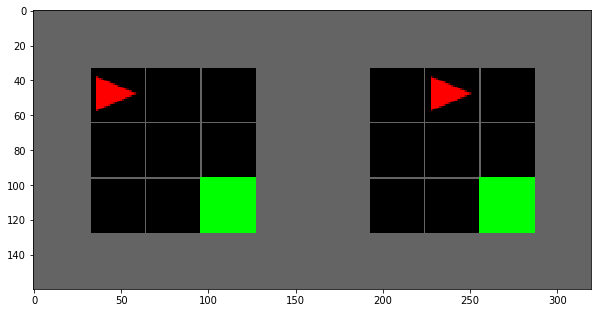

In [31]:
env = FlatObsWrapper(gym.make('MiniGrid-Empty-5x5-v0'))

# Reset the environment
obs=env.reset()
print(obs)
# Select the action right
action = env.actions.right
action= env.actions.forward
# Take a step in the environment and store it in appropriate variables
img_list=[]
img_list.append(env.render('rgb_array'))

obs, reward, done, info = env.step(action)
print(obs)
# Render the current state of the environment
img = env.render('rgb_array')
img_list.append(img)
################# YOUR CODE ENDS HERE ###############################


# print('Observation:', obs, ', Observation Shape: ', obs.shape)
# print('Reward:', reward)
# print('Done:', done)
# print('Info:', info)
# print('Image shape:', img.shape)
plt.imshow(np.concatenate([img_list[0], img_list[1]], 1));

In [18]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

In [10]:
class RandPolicy:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def act(self, *unused_args):
        return self.action_space.sample(), None

In [11]:
def log_policy_rollout(policy, env_name, pytorch_policy=False):
    # Create environment with flat observation
    env = gen_wrapped_env(env_name)

    # Initialize environment
    observation = env.reset()

    done = False
    episode_reward = 0
    episode_length = 0

    # Run until done == True
    while not done:
      # Take a step
        if pytorch_policy: 
            observation = torch.tensor(observation, dtype=torch.float32)
            action = policy.act(observation)[0].data.cpu().numpy()
        else:
            action = policy.act(observation)[0]
        observation, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()
    
    show_video()

# Test that the logging function is working
test_env_name = 'MiniGrid-Empty-8x8-v0'
rand_policy = RandPolicy(FlatObsWrapper(gym.make(test_env_name)).action_space)
log_policy_rollout(rand_policy, test_env_name)

Total reward: 0
Total length: 50
